In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mtalbert = pd.read_csv('../Data/soil data/AcrossAucklandRainfallStation/MtAlbert_Data_15mins.csv', index_col=['Timestamp (UTC+12:00)'], parse_dates=['Timestamp (UTC+12:00)'])
mtalbert.head()

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07 11:15:00,0.0,10.4,37.364
2018-07-07 11:30:00,0.0,10.4,37.594
2018-07-07 11:45:00,0.0,10.4,37.590
2018-07-07 12:00:00,0.0,10.5,37.587
2018-07-07 12:15:00,0.0,10.5,37.584


Resample Data to 60 minutes interval

In [2]:
mtalbert_daily = mtalbert.resample('D').agg({
    'Rain(mm)': 'sum',
    'SoilTemp(c)': 'mean',
    'SoilMoisture(%)': 'mean'
})

In [3]:
mtalbert_daily.head()

,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07,0.00,11.064706,37.337412
2018-07-08,7.36,11.355208,36.910969
2018-07-09,19.99,12.148958,40.972479
2018-07-10,7.88,11.923958,42.747948
2018-07-11,0.53,11.422581,42.727272


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [6]:
mtalbert_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2299 entries, 2018-07-07 to 2024-10-21
Freq: D
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         2299 non-null   float64
 1   SoilTemp(c)      1961 non-null   float64
 2   SoilMoisture(%)  1961 non-null   float64
dtypes: float64(3)
memory usage: 71.8 KB


In [7]:
mtalbert_daily.isna().sum()


Rain(mm)             0
SoilTemp(c)        338
SoilMoisture(%)    338
dtype: int64

In [8]:
mtalbert_daily = mtalbert_daily.dropna(subset=['SoilTemp(c)', 'SoilMoisture(%)'])
mtalbert_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1961 entries, 2018-07-07 to 2024-10-21
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         1961 non-null   float64
 1   SoilTemp(c)      1961 non-null   float64
 2   SoilMoisture(%)  1961 non-null   float64
dtypes: float64(3)
memory usage: 61.3 KB


In [9]:
mtalbert_daily.index = pd.to_datetime(mtalbert_daily.index)
period = 365
result = seasonal_decompose(mtalbert_daily['SoilMoisture(%)'], model='add', period=period)
result.plot(figsize=(20,4))
plt.show()

TypeError: DecomposeResult.plot() got an unexpected keyword argument 'figsize'

<Axes: xlabel='Timestamp (UTC+12:00)'>

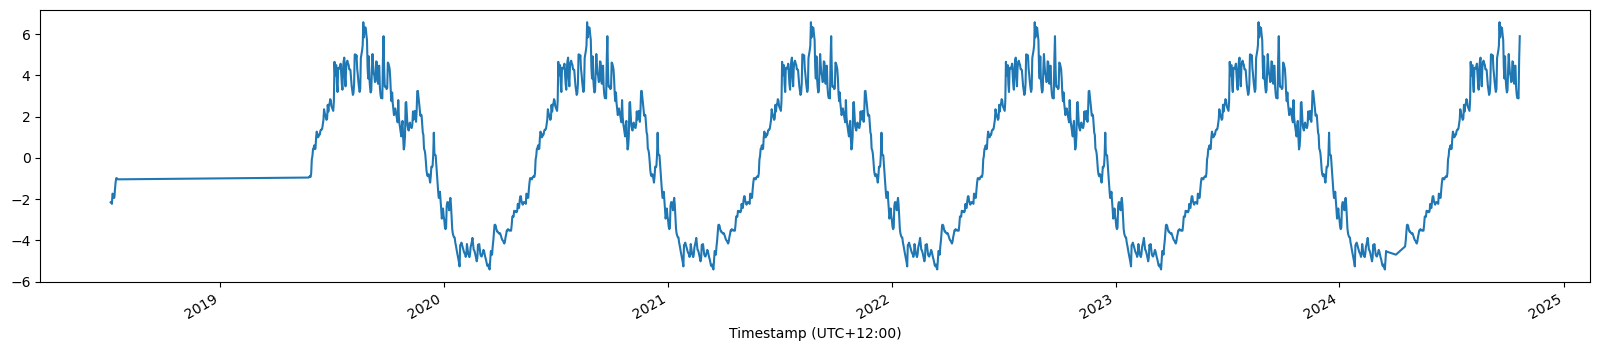

In [ ]:
result.seasonal.plot(figsize=(20,4))

In [ ]:
# Calculate 7-day rolling average for Rain(mm), SoilTemp(c), and SoilMoisture(%)
mtalbert_daily['Rain_7d_avg'] = mtalbert_daily['Rain(mm)'].rolling(window=7, min_periods=1).sum()
mtalbert_daily['SoilTemp_7d_avg'] = mtalbert_daily['SoilTemp(c)'].rolling(window=7, min_periods=1).mean()
mtalbert_daily['SoilMoisture_7d_avg'] = mtalbert_daily['SoilMoisture(%)'].rolling(window=7, min_periods=1).mean()

# Calculate 30-day rolling average for the same columns
mtalbert_daily['Rain_30d_avg'] = mtalbert_daily['Rain(mm)'].rolling(window=30, min_periods=1).sum()
mtalbert_daily['SoilTemp_30d_avg'] = mtalbert_daily['SoilTemp(c)'].rolling(window=30, min_periods=1).mean()
mtalbert_daily['SoilMoisture_30d_avg'] = mtalbert_daily['SoilMoisture(%)'].rolling(window=30, min_periods=1).mean()
mtalbert_daily.head()


,Rain(mm),SoilTemp(c),SoilMoisture(%),Rain_7d_avg,SoilTemp_7d_avg,SoilMoisture_7d_avg,Rain_30d_avg,SoilTemp_30d_avg,SoilMoisture_30d_avg
Timestamp (UTC+12:00),,,,,,,,,
2018-07-07,0.00,11.064706,37.337412,0.00,11.064706,37.337412,0.00,11.064706,37.337412
2018-07-08,7.36,11.355208,36.910969,7.36,11.209957,37.124190,7.36,11.209957,37.124190
2018-07-09,19.99,12.148958,40.972479,27.35,11.522958,38.406953,27.35,11.522958,38.406953
2018-07-10,7.88,11.923958,42.747948,35.23,11.623208,39.492202,35.23,11.623208,39.492202
2018-07-11,0.53,11.422581,42.727272,35.76,11.583082,40.139216,35.76,11.583082,40.139216


In [ ]:
for lag in [7, 14, 21, 30, 60]:  
    mtalbert_daily[f'Rain_lag_{lag}d'] = mtalbert_daily['Rain(mm)'].shift(lag)
mtalbert_daily = mtalbert_daily.dropna()

mtalbert_daily.head(20)

,Rain(mm),SoilTemp(c),SoilMoisture(%),Rain_7d_avg,SoilTemp_7d_avg,SoilMoisture_7d_avg,Rain_30d_avg,SoilTemp_30d_avg,SoilMoisture_30d_avg,Rain_lag_7d,Rain_lag_14d,Rain_lag_21d,Rain_lag_30d,Rain_lag_60d
Timestamp (UTC+12:00),,,,,,,,,,,,,,
2019-07-12,32.26,12.089583,45.147094,43.90,11.758929,44.646384,138.89,12.442674,44.219245,1.59,0.53,4.23,3.12,0.00
2019-07-13,0.53,12.189583,45.142698,43.90,11.806696,44.696057,138.38,12.400451,44.272487,0.53,0.00,0.00,1.04,7.36
2019-07-14,13.23,12.727083,47.275344,55.55,12.037946,45.073487,151.09,12.387569,44.387741,1.58,0.00,10.05,0.52,19.99
2019-07-15,1.58,12.213542,49.947208,56.07,12.127976,45.849010,146.96,12.341076,44.596262,1.06,2.12,5.82,5.71,7.88
2019-07-16,8.47,12.638542,46.204646,62.95,12.249107,46.090610,151.80,12.305035,44.672443,1.59,0.00,0.00,3.63,0.53
2019-07-17,5.81,12.362500,45.592802,62.41,12.363690,46.251400,157.09,12.279028,44.730292,6.35,1.06,0.00,0.52,1.05
2019-07-18,0.00,12.151042,45.452656,61.88,12.338839,46.394635,156.57,12.255764,44.781274,0.53,53.42,0.00,0.52,0.00
2019-07-19,11.64,12.239583,47.947208,41.26,12.360268,46.794652,168.21,12.267326,44.918420,32.26,1.59,0.53,0.00,1.05
2019-07-20,11.64,12.409375,49.910021,52.37,12.391667,47.475698,175.62,12.278125,45.127167,0.53,0.53,0.00,4.23,47.85


In [ ]:
len(mtalbert_daily) * 0.87

1653.87

In [ ]:
mtalbert_daily.iloc[1633]

Rain(mm)                  9.410000
SoilTemp(c)              24.039583
SoilMoisture(%)          46.053854
Rain_7d_avg              85.690000
SoilTemp_7d_avg          23.415923
SoilMoisture_7d_avg      43.048866
Rain_30d_avg            165.950000
SoilTemp_30d_avg         21.619514
SoilMoisture_30d_avg     43.836597
Rain_lag_7d              34.670000
Rain_lag_14d              0.000000
Rain_lag_21d              3.470000
Rain_lag_30d              0.000000
Rain_lag_60d              0.500000
Name: 2023-12-31 00:00:00, dtype: float64

In [ ]:
train = mtalbert_daily.iloc[:1633]
test = mtalbert_daily.iloc[1633:]


this to find the p, d, q and P,D, Q
- check model, check AIC

In [ ]:
from pmdarima import auto_arima

In [ ]:
# Winter: 90 days (December to February)
# Spring: 92 days (March to May)
# Summer: 92 days (June to August)
# Autumn: 91 days (September to November)
# Annual Seasonality (m = 365)

In [ ]:
auto_arima(mtalbert_daily['SoilMoisture(%)'], 
           exogenous=mtalbert_daily[['Rain(mm)', 'SoilTemp(c)', 'Rain_7d_avg', 'Rain_30d_avg', 'SoilTemp_30d_avg', 'Rain_lag_7d', 'Rain_lag_14d', 'Rain_lag_21d', 'Rain_lag_30d', 'Rain_lag_60d']], 
           seasonal=True, m=365 ).summary()

In [ ]:
from statmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['SoilMoisture(%)'],order=(0,1,1), seasonal_order=(1,0,1,365), enforece_invertibility=False)

In [ ]:
# model = SARIMAX(train['SoilMoisture(%)'], order=(0,1,1), seasonal_order=(1,0,1,12))

NameError: name 'train' is not defined

In [ ]:
results = model.fit()
result.sumary()

Predictive Model

In [ ]:
start = len(train)
end = len(train) + len(test) -1

In [ ]:
# train = mtalbert[['Rain(mm)', 'SoilTemp(c)']]
# test = mtalbert[['SoilMoisture(%)']]

In [ ]:
sarima_predictions = results.predict(start, end, typ="levels").rename('Sarima Predictions')

In [ ]:
test['SoilMoisture(%)'].plot(legend=True, figsize=(8,5))
sarima_predictions.plot(legend=True)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, mse, rmse, r2

sa_mae, sa_mse, sa_rmse, sa_r2 = evaluate_model(sarima_predictions, test)

print("\nRandom Forest Testing Set Metrics:")
print(f"MAE: {sa_mae}")
print(f"MSE: {sa_mse}")
print(f"RMSE: {sa_rmse}")
print(f"R2 Score: {sa_r2}")


Random Forest Testing Set Metrics:
MAE: 3.4216221902485104
MSE: 17.11547249036288
RMSE: 4.137085023342267
R2 Score: 0.3552786080951448


Forecast into the unknown future

In [ ]:
model = SARIMAX(mtalbert_daily['SoilMoisture(%)'], order=(0,1,1), seasonal_order=(1,0,1,12))
result = model.fit()

In [ ]:
fcast = results.predict(len(mtalbert_daily), len(mtalbert_daily) + 24)

In [ ]:
# # to see the prediction on the event:
# ax = test['SoilMoisture(%)'].plot(legend=True, figsize=(15,5))
# sarima_predictions.plot(legend=True)

# extremeEvent = 
# for day in test.query('Timestamp (UTC+12:00)')

In [ ]:
y_test_df = y_test.reset_index(drop=True)
predictions_df = pd.DataFrame(sarima_predictions, columns=['Predicted'])

results_df = pd.concat([y_test_df, predictions_df], axis=1)
results_df.index = mtalbert_daily.index[-len(y_test):] 

plt.figure(figsize=(8, 4))
plt.plot(mtalbert_daily['SoilMoisture(%)'][:len(X_train)], label='Train', color='blue')
plt.plot(results_df.index, results_df['Predicted'], color='red', label='Predicted')
plt.plot(results_df.index, results_df['SoilMoisture(%)'], color='green', label='Actual')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(14, 10))

# Temperature plot
plt.subplot(4, 1, 1)
plt.plot(mtalbert_daily.index, mtalbert_daily['SoilTemp(c)'], label='Temperature (C)', color='tab:orange')
plt.axvline(pd.Timestamp('2020-02-13'), color='red', linestyle='--', label='February 13, 2020')
plt.axvline(pd.Timestamp('2023-02-14'), color='green', linestyle='--', label='Cyclone Gabrielle (February 14, 2023)')
plt.axvline(pd.Timestamp('2023-05-09'), color='blue', linestyle='--', label='Storm Event (May 9, 2023)')
plt.title('Temperature')

# Rainfall plot
plt.subplot(4, 1, 2)
plt.plot(mtalbert_daily.index, mtalbert_daily['Rain(mm)'], label='Rainfall (mm)', color='skyblue')  
plt.axvline(pd.Timestamp('2020-02-13'), color='red', linestyle='--', label='February 13, 2020')
plt.axvline(pd.Timestamp('2023-02-14'), color='green', linestyle='--', label='Cyclone Gabrielle (February 14, 2023)')
plt.axvline(pd.Timestamp('2023-05-09'), color='blue', linestyle='--', label='Storm Event (May 9, 2023)')
plt.title('Rainfall')
plt.legend(loc ="center")

# Soil Moisture plot
plt.subplot(4, 1, 3)
plt.plot(mtalbert_daily.index, mtalbert_daily['SoilMoisture(%)'], label='Soil Moisture (%)', color='tab:olive')
plt.axvline(pd.Timestamp('2020-02-13'), color='red', linestyle='--', label='February 13, 2020')
plt.axvline(pd.Timestamp('2023-02-14'), color='green', linestyle='--', label='Cyclone Gabrielle (February 14, 2023)')
plt.axvline(pd.Timestamp('2023-05-09'), color='blue', linestyle='--', label='Storm Event (May 9, 2023)')
plt.title('Soil Moisture')

plt.tight_layout()
plt.show()